# Cloud Cover Detection Competition Model Experimentation with Torchgeo

## Import Required Libraries

In [21]:
# check to see if the dataset is available yet on Radiant MLHub, it wasn't

# from radiant_mlhub import Dataset
# for dataset in Dataset.list():
#     print(f'{dataset.id}: {dataset.title}')

In [23]:
from IPython.display import Image

In [1]:
import shutil
import rasterio
import random
import os
import tempfile
from rasterio.plot import show
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pytorch_lightning.loggers import CSVLogger
import torch
import xarray
import xrspatial.multispectral as ms

## Define global variables

In [2]:
# parent project directory
PROJECT_DIR = Path.cwd().parent.resolve() / "cloud_cover_competition"

# location of the training feature and label GeoTiff files
DATA_DIR = PROJECT_DIR / "data"
print(DATA_DIR)

# folder for the training feature GeoTiffs
TRAIN_FEATURES = DATA_DIR / "train_features"
assert TRAIN_FEATURES.exists()

# folder for the training label GeoTiffs
TRAIN_LABELS = DATA_DIR / "train_labels"
assert TRAIN_LABELS.exists()

/home/ying/cloud_cover_competition/data


In [3]:
feature_path = Path(PROJECT_DIR) / 'data' / 'train_features'
feature_path

PosixPath('/home/ying/cloud_cover_competition/data/train_features')

In [4]:
# chip_ids = [x for x in os.walk(feature_path) if x[0]][0][1]
# chip_ids

In [5]:
# these are the four bands that are available from the dataset
SENTINEL_BANDS = ["B02", "B03", "B04", "B08"]
RGB_BANDS = ["B02", "B03", "B04"]

## Observe Distribution of Dataset Across Locations

In [6]:
# import the metadata CSV file
train_metadata = pd.read_csv(PROJECT_DIR / "train_metadata.csv")
train_metadata.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [7]:
# aggregate the feature chips/images by location
feature_counts_by_location = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

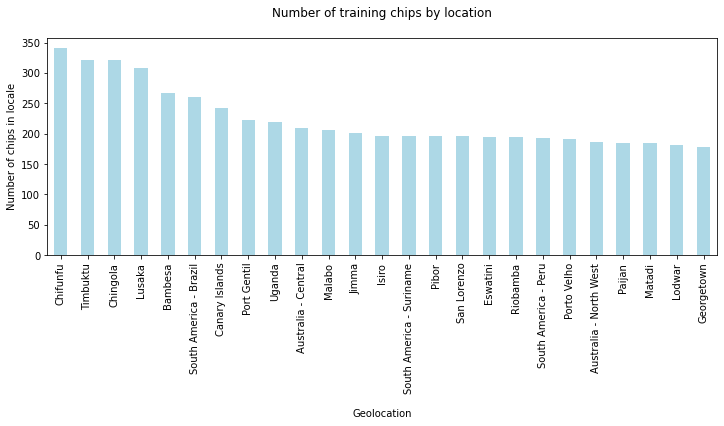

In [8]:
plt.figure(figsize=(12,4))
feature_counts_by_location.head(25).plot(kind="bar", color="lightblue")
plt.xticks(rotation=90)
plt.xlabel("\nGeolocation")
plt.ylabel("Number of chips in locale")
plt.title("Number of training chips by location\n")
plt.show()

## Construct full filepaths for each band by chip

In [8]:
def add_file_paths(df, feature_dir, label_dir=None, bands=SENTINEL_BANDS):
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()
    return df

In [9]:
train_meta = add_file_paths(train_metadata, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


## Preview the Image Data and Masks

In [10]:
def get_xarray(filepath):
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

In [11]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")
    return ms.true_color(r=red, g=green, b=blue)

In [12]:
def display_random_chip(random_state):
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    chid, location, label = random_chip.chip_id, random_chip.location, random_chip.label_path
    
    ax[0].imshow(true_color_img(chid))
    ax[0].set_title(f"Chip {chid}\n(Location: {location})")
    
    label_im = Image.open(label)
    print(np.array(label_im))
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {chid} label")
    plt.tight_layout()
    plt.show()
    
    print('-'*100)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


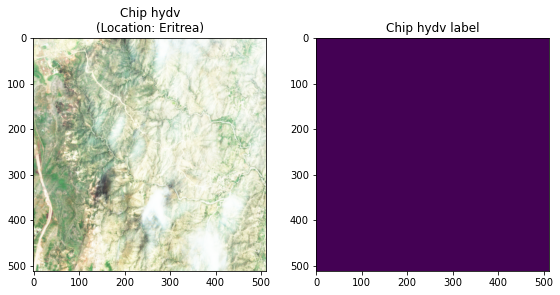

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


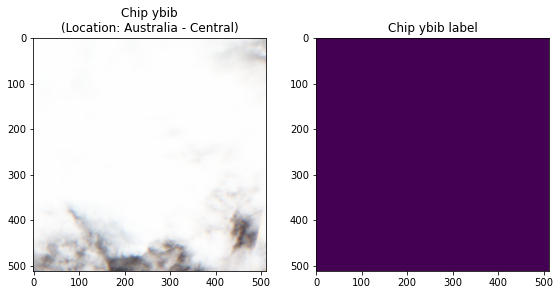

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


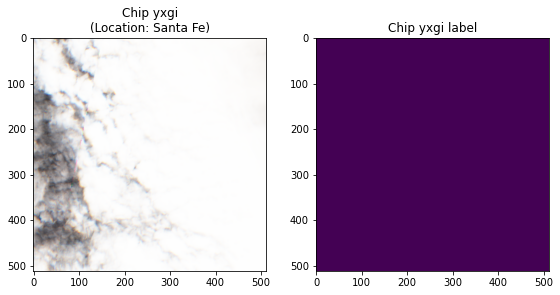

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


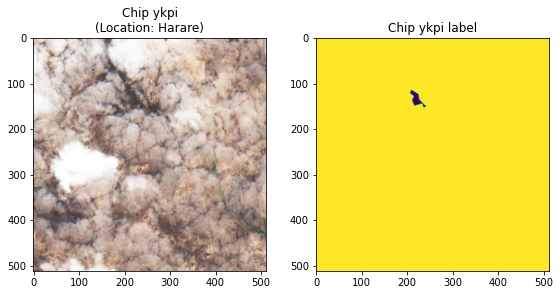

----------------------------------------------------------------------------------------------------
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


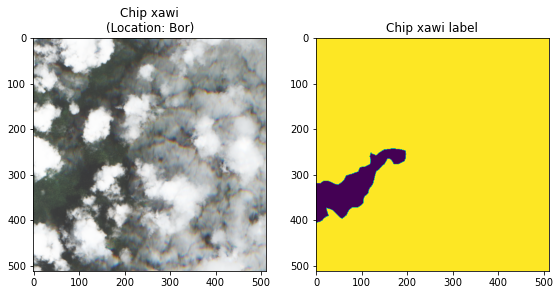

----------------------------------------------------------------------------------------------------


In [13]:
for i in range(5):
    random_index = random.randint(0, len(train_metadata))
    display_random_chip(random_index)

In [14]:
# assign column names for filepaths to each band
feature_cols = ["chip_id"] + [f"{band}_path" for band in SENTINEL_BANDS]

# feature variables
X = train_metadata[feature_cols].copy().reset_index(drop=True)

# target variable
y = train_metadata[["chip_id","label_path"]].copy().reset_index(drop=True)

In [15]:
X.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,adwp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
1,adwu,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
2,adwz,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
3,adxp,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...,/home/ying/cloud_cover_competition/data/train_...


In [16]:
y.head()

,chip_id,label_path
0,adwp,/home/ying/cloud_cover_competition/data/train_...
1,adwu,/home/ying/cloud_cover_competition/data/train_...
2,adwz,/home/ying/cloud_cover_competition/data/train_...
3,adxp,/home/ying/cloud_cover_competition/data/train_...
4,aeaj,/home/ying/cloud_cover_competition/data/train_...


In [17]:
X.shape, y.shape

((11748, 5), (11748, 2))

## Train a Semantic Segmentation Model with DeepLabV3 vs. FarSeg Architectures (& ResNet50 backbone)

One architecture I was excited to experiment with after readinging about it is called FarSeg. The full name is Foreground-Aware Relational Network for Geospatial Object Segmentation (FarSeg). It's a mouth full, as are most of these architectures. After digging a little further, I saw another architecture I wanted to experiement with other than Unet, called DeepLabs V3, which is a deep convolutional network using a special Atrous convolution, and fully connected condtional random field (CRFs). The end goal was to try at least these two architectures as well as a third if there was time, given training time is long on these large datasets even with a descent GPU. The DeepLab V3 architecture is what is used by the model below. The training task isn't completing because of a bug in how the custom DataModule is being created so that the cloud cover dataset can be wrapped up and paired with  semantic segmentation tool in the [`torchgeo` library](https://torchgeo.readthedocs.io/en/latest/).

At first I tried to implement the dataset created from the `cloud_benchmark.ipynb` using the FarSeg model built into `torchgeo` but I kept running into an error. After digging further and discussing with the Microsoft `torchgeo` team, a more fundamental tid-bit was brought to my attention, that FarSeg was extending a generic PyTorch `Module`, while the `SemanticSegmentationTask` expected a `LightningModule`. The FarSeg (in its current form) model wasn't compatible with the dataset, and conversely, the model using a `LightningModule` I already created wasn't exactly compatible with the built-in `SemanticSegmentationTask`. This meant I had a few options to move forward and build a model to compare to the benchmark:

1. Completely rewrite the CloudUnet as an nn.Module instead of a pl.LightningModule
2. Refactor the CloudUnet to debug and make it work with the SemanticSegmentationTask
3. Build a new Dataset and DataModule to be compatible with pl.LightningModule to work with SemanticSegmentationTask

In the end option 3 seemed to be the most straightforward, extensible, and had the support of the Microsoft team because if I get this working, it is a viable contribution to the project in their GitHub repository, and will make the dataset available for anyone, including others in the competition, to be be able to easily download and train a model with that dataset in the future. The `cloud.py` script contains two custom classes that extend a base class Dataset and the PyTorch Lightning DataModule that would be compatible with any [SemanticSegmentationTask](https://torchgeo.readthedocs.io/en/latest/api/trainers.html#torchgeo.trainers.SemanticSegmentationTask).

### Model Architecture Diagram for FarSeg

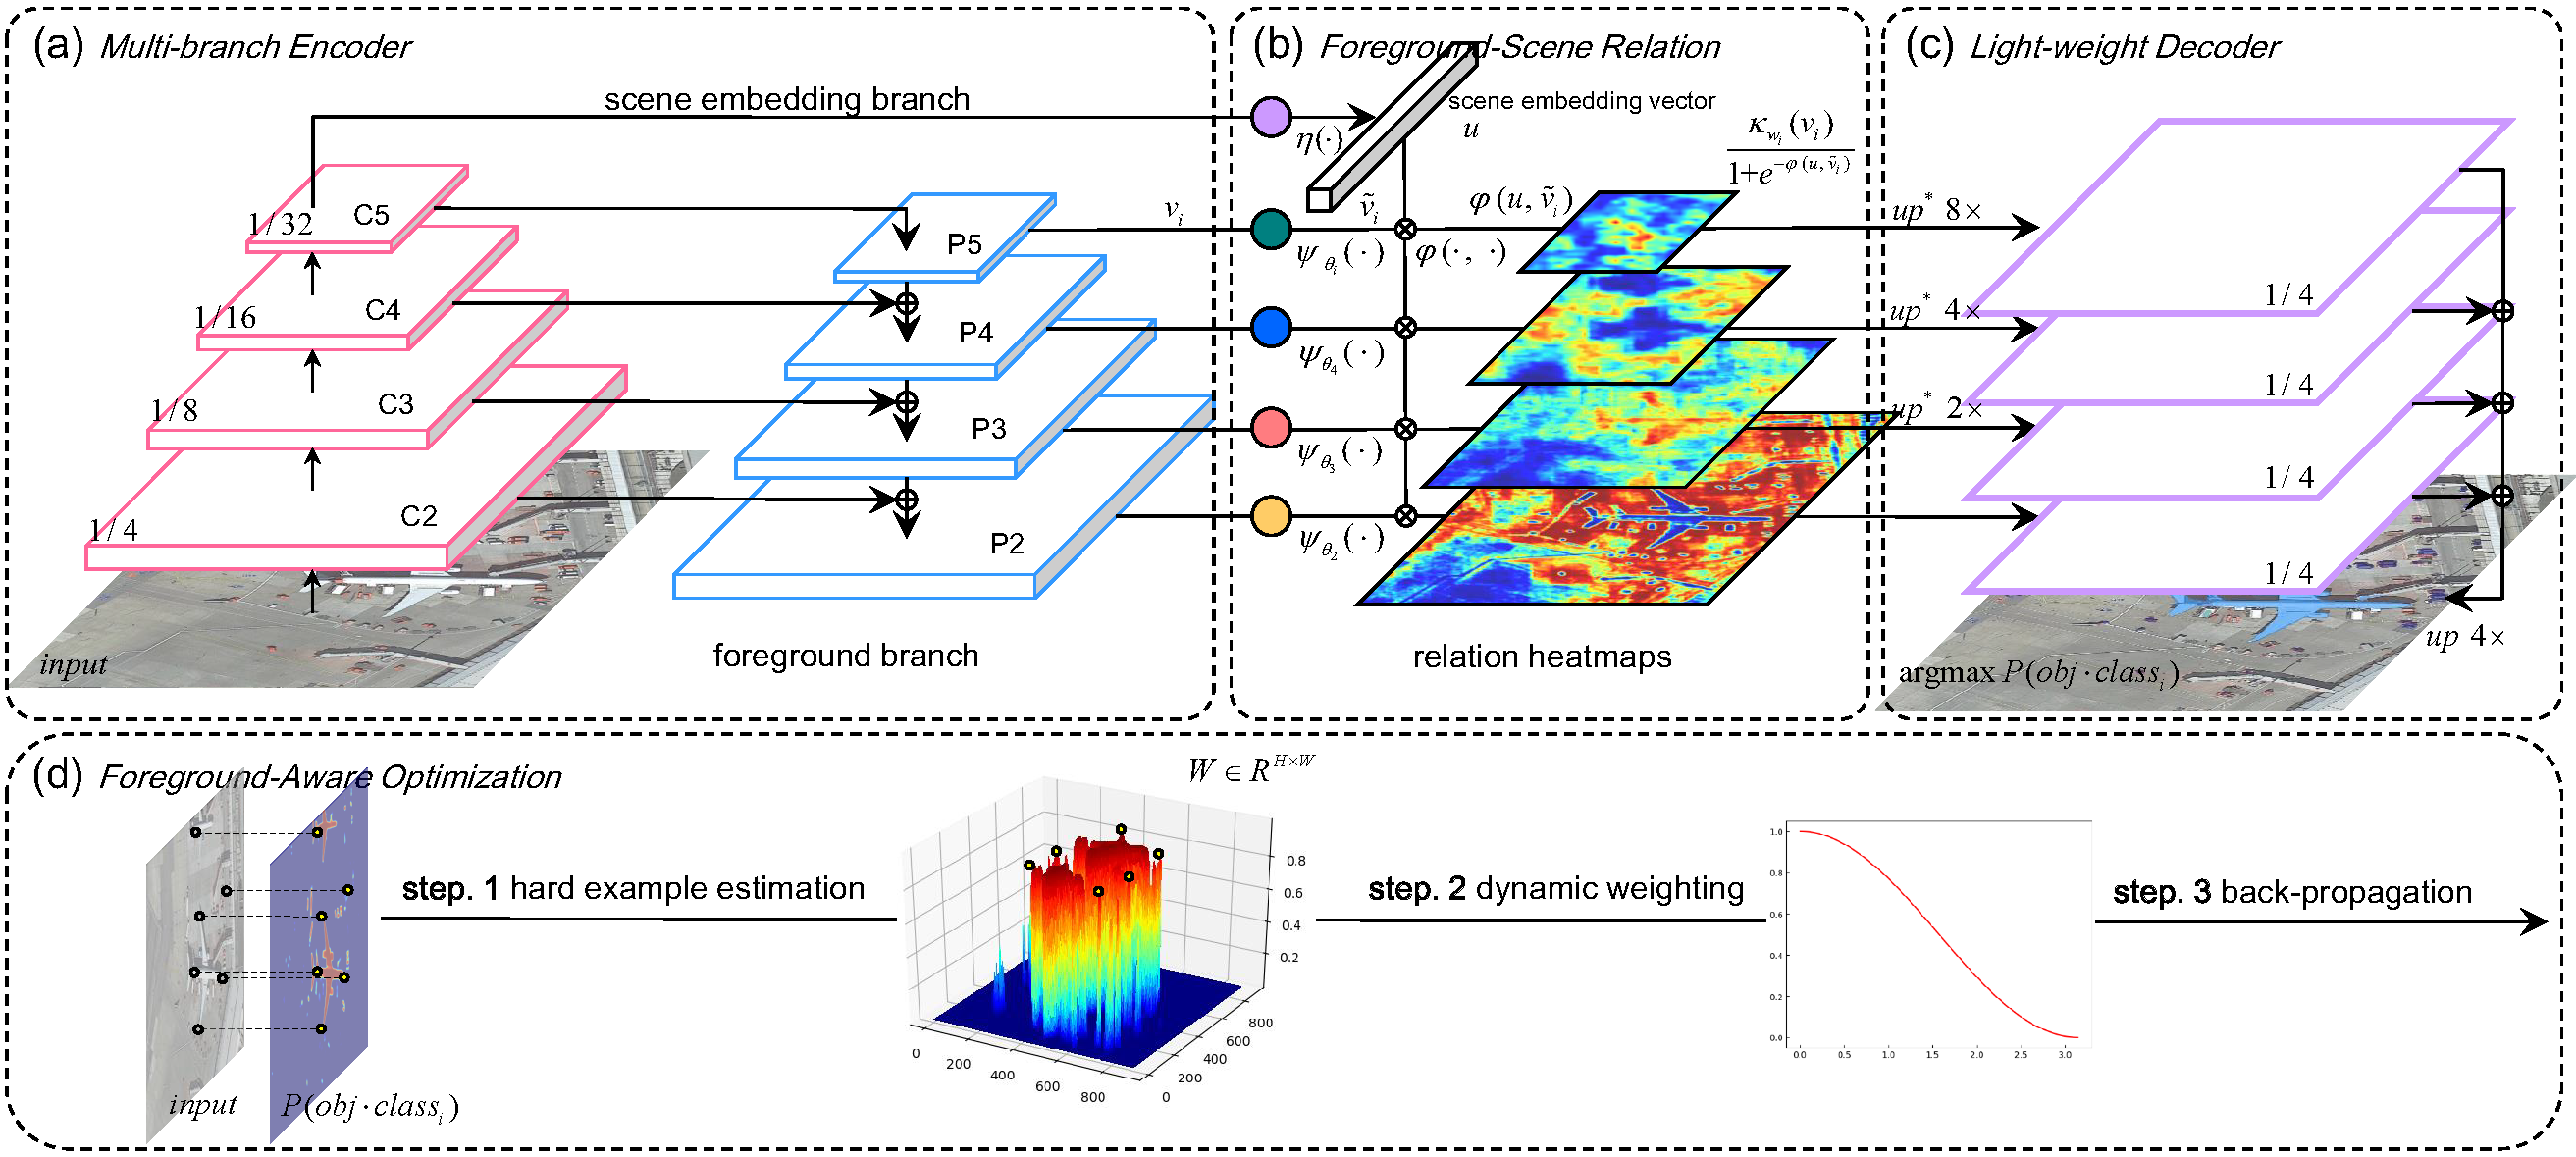

In [25]:
Image('https://raw.githubusercontent.com/Z-Zheng/images_repo/master/farseg.png')

For a detailed description of the **FarSeg** model, please reference the published paper [here] (https://arxiv.org/abs/2011.09766).

### Model Architecture Diagram for DeepLabs V3

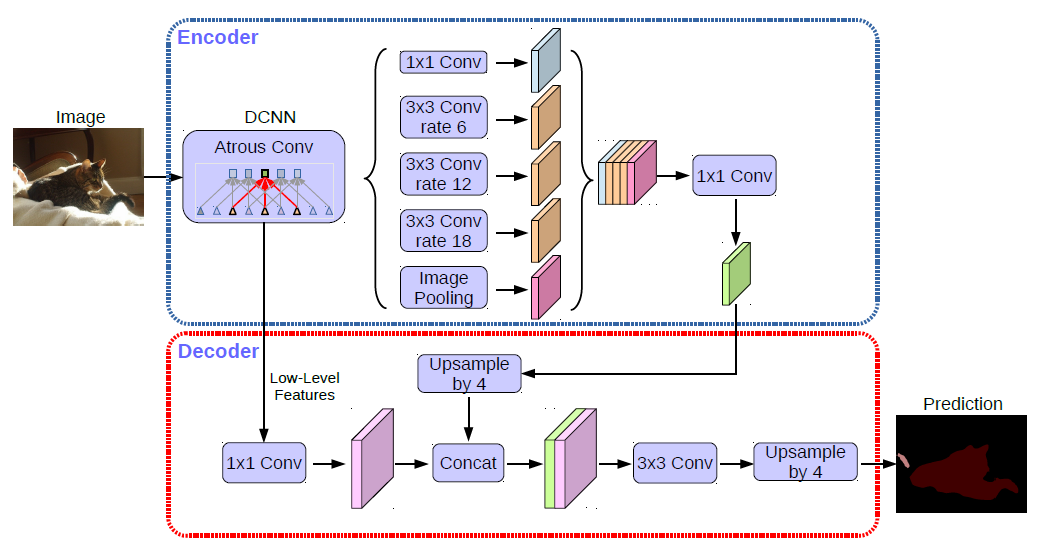

In [29]:
Image('deep_labs_model_graph.png')

For a detailed description of the DeepLabs V3 model, please reference the published paper [here] (https://arxiv.org/pdf/1606.00915.pdf).

### Instantiate SemanticSegmentationTask and CloudCoverDataModule

In [6]:
from torchgeo.trainers import SemanticSegmentationTask

In [7]:
from cloud import Sentinel2CloudCover
from cloud import Sentinel2CloudCoverDataModule

In [8]:
N_CLASSES = 2

In [9]:
# this instantiates the semanticsegmentation task with some hyperparameters

semseg_task = SemanticSegmentationTask(
    segmentation_model="deeplabv3+", 
    encoder_name="resnet50", 
    encoder_weights="imagenet", 
    in_channels=4, 
    num_classes=N_CLASSES,
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
    loss="jaccard",
    ignore_zeros=False
)

In [10]:
# this instantiates the custom datamodule with some other hyperparameters
cloud_module = Sentinel2CloudCoverDataModule(
    root_dir=DATA_DIR,
    seed=42,
    batch_size=4,
    num_workers=6,
    n_classes=N_CLASSES,
)

In [11]:
# validating the module was instantiated correctly
cloud_module.batch_size

4

In [12]:
# cloud_module.prepare_data()

In [13]:
experiment_dir = os.path.join(tempfile.gettempdir(), "cloud_results")

In [14]:
# Checkpoint callback writes progress on each epoch batch
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=experiment_dir,
    monitor="iou_epoch",
    mode="max", 
    verbose=True
)

In [15]:
# Early Stopping callback looks for when the model stops improving
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    mode="max",
    verbose=True,
)

In [16]:
# csv logger to store IoU and loss on each epoch
csv_logger = CSVLogger(
    save_dir=experiment_dir,
    name="training_logs"
)

In [17]:
# This instantiates a PyTorch Lightning Trainer object
lightning_trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[csv_logger],
    default_root_dir=experiment_dir,
    min_epochs=1,
    max_epochs=15,
    fast_dev_run=True
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/ying/anaconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1579: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


In [18]:
# check to make sure GPU is available
torch.cuda.is_available()

In [19]:
# Empty the cache in case something else is using GPU
torch.cuda.empty_cache()

In [20]:
# train the model!!!
lightning_trainer.fit(model=semseg_task, datamodule=cloud_module)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | DeepLabV3Plus    | 26.7 M
1 | loss          | JaccardLoss      | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.724   Total estimated model params size (MB)
/home/ying/anaconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:412: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Loading chip id: pcgi
Loading chip id: yglg

Loading chip id: ibjw

Loading chip id: hwnk
Loading chip id: ynlb



Loading chip id: yilq

Loading chip id: mtqz

Loading chip id: vafw

Loading chip id: kzvr

Loading chip id: aqgj

Loading chip id: hyqa

Loading chip id: ahoz

Loading chip id: vjcr

Loading chip id: zafv

Loading chip id: vxtw
Loading chip id: mbcx


Loading chip id: yifm

Loading chip id: xqqv

Loading chip id: vptv

Loading chip id: dysx

Loading chip id: ncia

Loading chip id: ixmd

Loading chip id: wnch

Loading chip id: ghge

Loading chip id: zcnu

Loading chip id: zvyr

Loading chip id: xcic

Loading chip id: clvy
Loading chip id: ryrv


Loading chip id: sxln

Loading chip id: dfgu

Loading chip id: mped
Loading chip id: cvvr


Loading chip id: ycjk

Loading chip id: lxdb

Loading chip id: lcqm

Loading chip id: hpwa

Loading chip id: lulw
Loading chip id: jety

Loading chip id: iwur


Loading chip id: euyu

Loading chip id: mvmr

Loading chip id: rwlv

Loading chi

RuntimeError: one_hot is only applicable to index tensor.

## Evaluate Model Performance

I was never able to train the model, therefore no performance to be evaluated. T.T

If you're interested, please see the latest issue submitted to the `torchgeo` library:
https://github.com/microsoft/torchgeo/issues/303

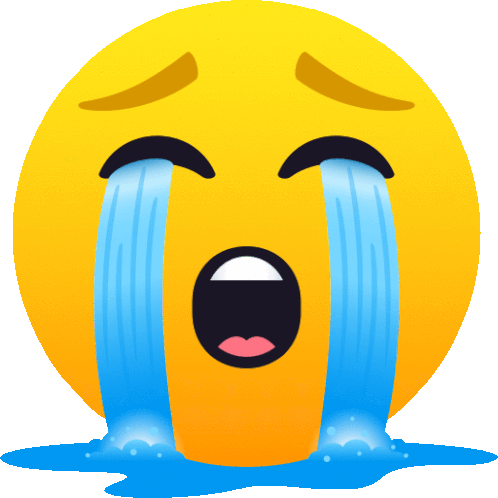

In [30]:
Image('https://c.tenor.com/q4-20mdcdeYAAAAi/loudly-crying-face-people.gif')

## Appendix

### Experimenting with way sof fetching all the bands from a folder

In [44]:
import re, os, glob
from tqdm import tqdm

In [66]:
filename_glob = "*.tif"
pathname = os.path.join(DATA_DIR, "**", filename_glob)

feature_filename_regex = """^(?P<band>B\d{2})"""
feature_filename_regexer = re.compile(feature_filename_regex, re.VERBOSE)

label_filename_regex = """^(?P<band>B\d{2})"""
label_filename_regexer = re.compile(label_filename_regex, re.VERBOSE)

matches = []

In [62]:
for filepath in glob.iglob(pathname, recursive=True):
    feature_match = re.match(feature_filename_regexer, os.path.basename(filepath))
    label_match = re.match(label_filename_regexer, os.path.basename(filepath))
    if match is not None:
        matches.append(filepath)

In [63]:
matches[0:5]

['/home/ying/cloud_cover_competition/data/train_features/ckto/B08.tif',
 '/home/ying/cloud_cover_competition/data/train_features/ckto/B03.tif',
 '/home/ying/cloud_cover_competition/data/train_features/ckto/B04.tif',
 '/home/ying/cloud_cover_competition/data/train_features/ckto/B02.tif',
 '/home/ying/cloud_cover_competition/data/train_features/rsuh/B08.tif']

In [64]:
matches[-5:]

['/home/ying/cloud_cover_competition/data/train_features/obnz/B02.tif',
 '/home/ying/cloud_cover_competition/data/train_features/wltz/B08.tif',
 '/home/ying/cloud_cover_competition/data/train_features/wltz/B03.tif',
 '/home/ying/cloud_cover_competition/data/train_features/wltz/B04.tif',
 '/home/ying/cloud_cover_competition/data/train_features/wltz/B02.tif']

In [59]:
matches[0].split('/')

['',
 'home',
 'ying',
 'cloud_cover_competition',
 'data',
 'train_features',
 'ckto',
 'B02.tif']

In [ ]:
# [x for b in a for x in b]

In [77]:
# [y.split('/')[-1] for x in os.walk(DATA_DIR) for y in x[0]]

In [82]:
walk = [x for x in os.walk(TRAIN_FEATURES) if x[0]]

In [86]:
len(walk[0][1])

11748

### Failed way using FarSeg Architecture

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5)

In [ ]:
# X_train = X_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# X_val = X_val.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
# y_val = y_val.reset_index(drop=True)

In [ ]:
# X_train.shape, X_test.shape, X_val.shape

In [ ]:
# y_train.shape, y_test.shape, y_val.shape

In [ ]:
# # create a folder for model output if it doesn't exist already
# model_dir = Path("model_output")

# if not model_dir.exists():
#     model_dir.mkdir(parents=True)

In [ ]:
# try:
#     from farseg_src.cloud_model import CloudFarSegModel
# except ImportError:
#     print(f"Error on import of CloudModel class")

In [ ]:
# farseg_model = CloudFarSegModel(
#     bands=RGB_BANDS,
#     x_train=X_train,
#     y_train=y_train,
#     x_val=X_val,
#     y_val=y_val
# )

In [ ]:
# lightning_trainer = pl.Trainer(
#     gpus=1,
#     fast_dev_run=True, # this parameter does a dev run to see if model will train
#     callbacks=[checkpoint_callback, early_stopping_callback],
#     logger=csv_logger,
#     log_every_n_steps=50
# )

In [ ]:
# lightning_trainer.fit(model=farseg_model)

In [ ]:
# model_weight_path = model_dir / "cloud_model.pt"
# torch.save(farseg_model.state_dict(), model_weight_path)

In [ ]:
# checkpoint_file = '/home/ying/cloud_cover_competition/lightning_logs/version_6/checkpoints/epoch=14-step=14759.ckpt'

In [ ]:
# checkpoint = torch.load(checkpoint_file)

In [ ]:
# cloud_model.load_state_dict(checkpoint['state_dict'])